# TP3 - sistema de travagem ABS (“Anti-Lock Breaking System”)
### Exercício 1
Grupo 05

    Eduardo André Silva Cunha A98980
    Gonçalo Emanuel Ferreira Magalhães A100084

Pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. 
- o modo `Start` inicia o funcionamento com os valores iniciais das velocidades
- no modo `Free`  não existe qualquer força de travagem; 
- no modo `Stopping` aplica-se a força de travagem alta; 
- no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  move-se (i.e. derrapa) com pequeno atrito ao solo;  
- no modo `Stopped` o veículo está imobilizado.

A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`   e a `velocidade linear das rodas`  ambas em relação so solo.
Assume-se que o sistema de travagem exerce uma força de atrito proporcional à diferença das duas velocidades.  A dinâmica contínua, as equações de fluxo, está descrita  abaixo.
Os “switchs” são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser  de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.
É imprescindível evitar que o sistema tenha “trajetórias de Zenão”. Isto é, sequências  infinitas de transições  entre dois modos em intervalos de tempo  que tendem para zero mas nunca alcançam zero.

### Faça 

1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
2. A condição de segurança estabelece que o sistema não permaneça no modo `free`  ou no modo `blocked` mais do que $\,\tau\,$ segundos.
3. Defina um SFOTS que modele a discretização do autómato híbrido.
4. Verifique nesse modelo
    - A) Que as condições de segurança são invariantes do sistema
    - B) Que o sistema atinge o estado `stopped` eventualmente.

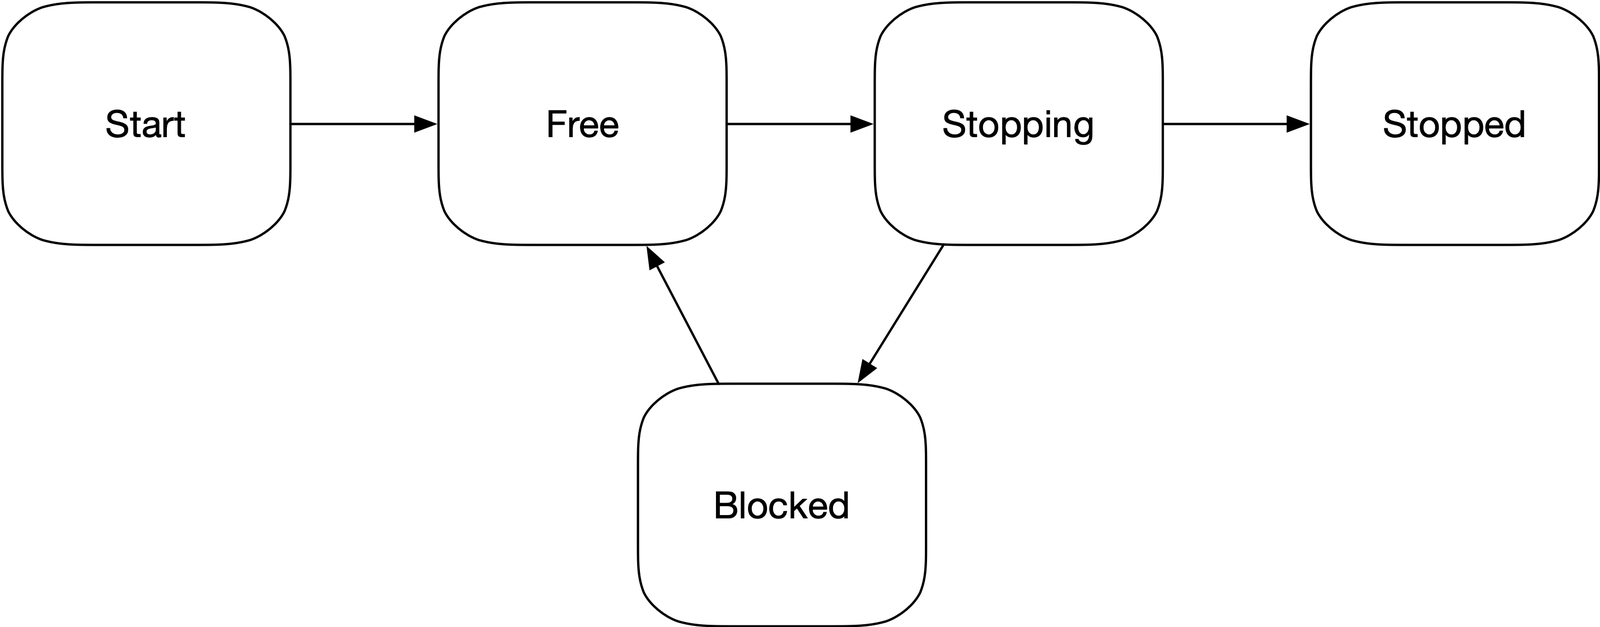

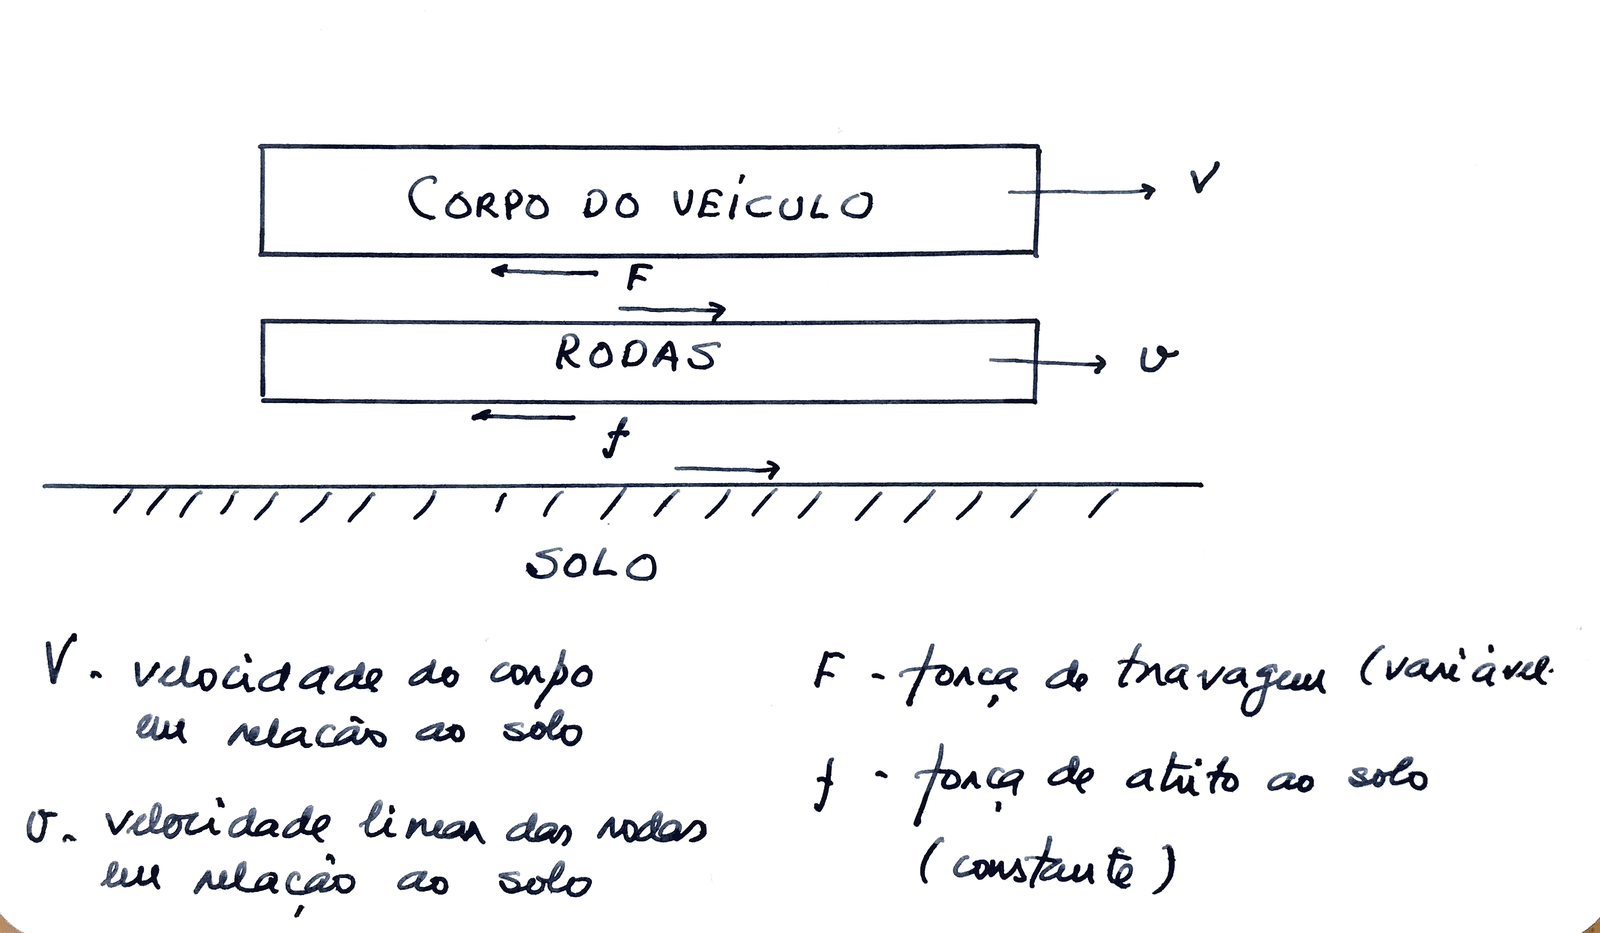

### Equações de Fluxo 

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 
2. No contacto rodas/solo a força de compressão é dada pelo o peso $P$ que é constante e independente do modo. Tem-se $f = a\, P$ sendo  $a$ a constante de atrito; o valor de $a$ depende do modo: é baixa em `Blocked` e alta nos restantes.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades $F =  c\, (V-v)$
A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.
4. As  equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,$(\dot{V} \,=\, -F)\,\land\, (\dot{v} \,=\, -a\, P  + F)$
e , no modo `Blocked`,  a dinâmica do sistema é  regida por $(V = v) \;\land\; (\,\dot{v}\,=\, -a\, P\,)$
6. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que o controlo aí permaneça mais do que $\,\tau\,$ segundos.  Os  $\mathsf{switch}(V,v,t,V',v',t')\,$  nesses modos devem forçar esta condição. 
7. Todos os “switchs” devem ser construídos de  modo a impedir a existência de trajetórias de Zenão.
8. No instante inicial  o modo é  `Start` e  tem-se $\,V = v\,=\,V_0$  . A velocidade $V_0$ é  “input” do problema.

### Alinea 1 - Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.


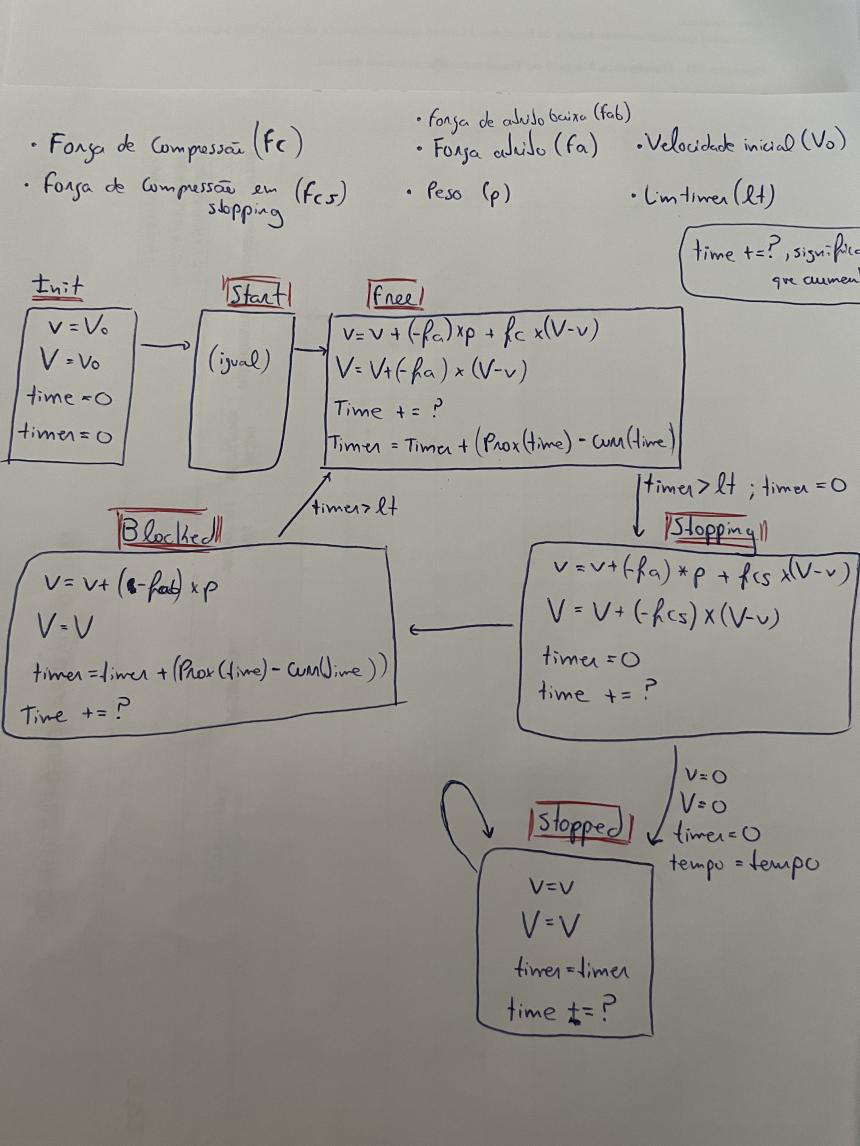

### Alinea 2 - A condição de segurança estabelece que o sistema não permaneça no modo `free`  ou no modo `blocked` mais do que $\,\tau\,$ segundos.


#### Verificação de autómatos híbridos com FOTS

Com o objetivo de assegurar que o sistema não permanece no modo `free` ou `blocked` por mais tempo do que $\,\tau\,$, decidimos implementar a seguinte ideia:

A proposta consiste em incorporar, nos estados do FOTS, além das variáveis contínuas do autômato híbrido, duas variáveis especiais:
- uma variável contínua que representa o $tempo$ 
- uma variável discreta que representa o $timer$

A variável $tempo$ irá contabilizar continuamente o $tempo$ de interação do sistema, enquanto a variável $timer$ apenas registrará o $tempo$ em que o sistema se encontra no estado `free` ou `blocked`, sendo resetada na saída desse estado. 

A variável $timer$ será calculada pela seguinte equação:

- $timer$ = $timer$ + (prox($time$) - curr($time$))

### Alinea 3 - Defina um SFOTS que modele a discretização do autómato híbrido.

#### Imports

In [23]:
from pysmt.shortcuts import *
from pysmt.typing import *

#### Constantes globais

In [24]:
# Estados - Switches
global START
START = Int(0)

global FREE
FREE = Int(1)

global STOPPING
STOPPING = Int(2)

global BLOCKED
BLOCKED = Int(3)

global STOPPED
STOPPED = Int(4)


# Atributos que definimos
global forca_compressao         # c
forca_compressao = Real(0.1)

global forca_compressao_stopping           
forca_compressao_stopping = Real(1)

global forca_atrito             # a
forca_atrito = Real(0.05)

global forca_atrito_baixa       # a no estado blocked
forca_atrito_baixa = Real(0.01)

global peso                     # P
peso = Real(1500.0)

global limTimer #tempo maximo do timer
limTimer = Real(0.2)

global velocidade_inicial       # V0
velocidade_inicial = Real(20.0)


## Versão do Código com Input de Velocidade: 
# x = input("Velocidade Inicial: ")
# x_real = float(x)
# velocidade_inicial = Real(x_real)


# variavel criada para evitar as trajetorias de zenao
global tempo_minimo_estado
tempo_minimo_estado = Real(0.05)


#### Função declare

In [25]:
def declare(i):
    s = {}
    s['pc'] = Symbol('pc'+str(i),INT)           # estado: start,free,stopping,blocked,stopped
    s['v'] = Symbol('v'+str(i),REAL)            # velocidade das rodas em rel ao solo
    s['V'] = Symbol('V'+str(i),REAL)            # velocidade do corpo em rel ao solo
    s['timer'] = Symbol('timer'+str(i), REAL)   # timer para contar tempo em free e blocked
    s['tempo'] = Symbol('tempo'+str(i), REAL)   # tempo total
    return s

#### Função init

In [26]:
def init(s):                
    return And(Equals(s['v'], velocidade_inicial), Equals(s['V'], velocidade_inicial), # Velocidade do Carro e das rodas igual a V0
               Equals(s['pc'], START),                                                 # Estado Inicial : Start
               Equals(s['timer'], Real(0)), Equals(s['tempo'], Real(0))                # Timer e Tempo iniciados a 0
              )

#### Função transições

In [27]:
def trans(curr, prox):
    
    #sames:                                                # Mantem o próximo estado igual ao anterior
    same_v = Equals(curr['v'],prox['v'])
    same_V = Equals(curr['V'],prox['V'])
    same_time = Equals(curr['tempo'],prox['tempo'])
    same_timer = Equals(curr['timer'],prox['timer'])


    # untimed: Troca de Switchs
    # Start -> Free
    StartToFree = And(Equals(curr['pc'], START), Equals(prox['pc'], FREE),              
                      same_v, same_V, same_time, same_timer                         # mantem se tudo igual
                     )

    # Free -> Stopping
    FreeToStopping = And(Equals(curr['pc'], FREE), Equals(prox['pc'], STOPPING),
                         same_v, same_V, same_time,
                         Equals(prox['timer'], Real(0))                            # timer resetado a 0
                     )

    # Stopping -> Blocked
    StoppingToBlocked = And(Equals(curr['pc'], STOPPING), Equals(prox['pc'], BLOCKED),
                             same_v,                                        
                             same_V,                                        # Mantem as mesmas velocidades
                             Equals(prox['timer'], Real(0)),                # timer mantem-se a 0
                             same_time                                      # tempo mantem-se
                            )

    # Blocked -> Free
    BlockedToFree =    And(Equals(curr['pc'], BLOCKED), Equals(prox['pc'], FREE),
                             same_v,                                        # Velocidades mantem-se
                             same_V ,
                             Equals(prox['timer'], Real(0)),                # timer resetado a 0                         
                             same_time                                      # tempo mantem-se
                             
                            )
    
    # Stopping -> Stopped
    StoppingToStopped = And(Equals(curr['pc'], STOPPING), Equals(prox['pc'], STOPPED),  
                             Equals(prox['v'], Real(0)),                    # Velocidades a 0
                             Equals(prox['V'], Real(0)),
                             Equals(prox['timer'], Real(0)),                # Timer a 0
                             same_time,                                     # Tempo mantem-se
                            )

    untimed = Or(StartToFree, FreeToStopping, StoppingToBlocked, BlockedToFree, StoppingToStopped)
    

    # Timed
    # Free -> Free
    FreeToFree = And(Equals(curr['pc'], FREE), Equals(prox['pc'], FREE),     
                     
                     # Equacao da dinamica do sistema           
                     Equals(prox['v'], curr['v'] + (-forca_atrito)*peso + forca_compressao*(curr['V'] - curr['v'])), 
                     Equals(prox['V'], curr['V'] + (-forca_compressao)*(curr['V'] - curr['v'])),    
                     
                     GT(prox['tempo'], curr['tempo']),                                         # Tempo aumenta
                     LE(prox['tempo'] - curr['tempo'], limTimer),
                     GT(prox['tempo'] - curr['tempo'], tempo_minimo_estado),                   # Evita as trajetórias de zenão 
                                                                                               
                                                                                               # Alinea 2)
                     LE(prox['timer'], limTimer),                                              # Garante que o timer não excede o limite
                     Equals(prox['timer'], curr['timer']+(prox['tempo']-curr['tempo']))

                          
                     )
    
    # Stopping -> Stopping
    StoppingToStopping = And(Equals(curr['pc'], STOPPING), Equals(prox['pc'], STOPPING),
                             # Equacoes da dinamica do sistema
                             Equals(prox['v'], curr['v'] + ((-forca_atrito)*peso) + (forca_compressao_stopping*(curr['V'] - curr['v']))), 
                             Equals(prox['V'], curr['V'] + (-forca_compressao_stopping)*(curr['V'] - curr['v'])),

                             Equals(prox['timer'], Real(0)),                        # timer mantem-se a 0
                             
                             GT(prox['tempo'], curr['tempo']),                      # tempo aumenta
                             LE(prox['tempo'] - curr['tempo'], limTimer),
                             GT(prox['tempo'] - curr['tempo'], tempo_minimo_estado)                   # Evita as trajetórias de zenão 
                            )
    
    # Blocked -> Blocked
    BlockedToBlocked = And(Equals(curr['pc'], BLOCKED), Equals(prox['pc'], BLOCKED),
                     Equals(prox['v'], curr['v'] + (-forca_atrito_baixa)*peso),                   # Vel das rodas e diminuida dado o atrito
                     Equals(prox['V'], curr['V']),                                          # Vel do veiculo mantem
                    
                     GT(prox['tempo'], curr['tempo']),                                      # tempo avança
                     LE(prox['tempo'] - curr['tempo'], limTimer),
                     GT(prox['tempo'] - curr['tempo'], tempo_minimo_estado),                   # Evita as trajetórias de zenão 
                                                                                            
                                                                                            # Alinea 2)
                     LE(prox['timer'], limTimer),                                           # garante que o tempo do timer nao ultrapassa o lim definido
                     Equals(prox['timer'], curr['timer']+(prox['tempo']-curr['tempo']))    
                     )

    # Stopped -> Stopped
    StoppedToStopped = And(Equals(curr['pc'], STOPPED), Equals(prox['pc'], STOPPED),
                             same_v,                                                    # Velocidades metem-se 0
                             same_V,
                             same_timer,                                                # Timer mantem-se 0
                             GT(prox['tempo'], curr['tempo']),                          # Tempo aumenta
                             LE(prox['tempo'] - curr['tempo'], limTimer),
                             GT(prox['tempo'] - curr['tempo'], tempo_minimo_estado)     # Evita as trajetórias de zenão 
                            )
    
    timed = Or(FreeToFree, StoppingToStopping, BlockedToBlocked, StoppedToStopped)
    
    
    return Or(timed, untimed)

#### Função geradora de traço

In [28]:
def gera_traco(declare,init,trans,k):
    l = ['START', 'FREE', 'STOPPING', 'BLOCKED', 'STOPPED']
    with Solver(name="z3") as s:
          
        # Cria o traço
        trace = [declare(i) for i in range(k+1)]

        # Garante o estado inicial definido pela func Init
        s.add_assertion(init(trace[0]))
        for i in range(k):
            # Garante as transições dadas pela func Trans
            s.add_assertion(trans(trace[i], trace[i+1]))

            # garante que todos os atributos são positivos
            for v in trace[i]:
                if v not in ['pc']:
                    s.add_assertion(trace[i][v] >= 0)

        # Restrição adicional: o último estado deve ser STOPPED
        # Talvez não necessária
        s.add_assertion(Equals(trace[-1]['pc'], STOPPED))
        
        if s.solve():
            for i in range(k+1):
                print()
                print("Estado:",i)
                m = s.get_py_value(trace[i]['pc'])
                print("Switch ->",l[m])
                for v in trace[i]:
                    if v not in ['pc']:
                        aux = s.get_py_value(trace[i][v])
                        print(f'{v}: ' + '%.2f' % float(aux))
        else:
            print('unsat')
                
gera_traco(declare,init,trans,10)


Estado: 0
Switch -> START
v: 20.00
V: 20.00
timer: 0.00
tempo: 0.00

Estado: 1
Switch -> FREE
v: 20.00
V: 20.00
timer: 0.00
tempo: 0.00

Estado: 2
Switch -> STOPPING
v: 20.00
V: 20.00
timer: 0.00
tempo: 0.00

Estado: 3
Switch -> BLOCKED
v: 20.00
V: 20.00
timer: 0.00
tempo: 0.00

Estado: 4
Switch -> BLOCKED
v: 5.00
V: 20.00
timer: 0.20
tempo: 0.20

Estado: 5
Switch -> FREE
v: 5.00
V: 20.00
timer: 0.00
tempo: 0.20

Estado: 6
Switch -> STOPPING
v: 5.00
V: 20.00
timer: 0.00
tempo: 0.20

Estado: 7
Switch -> BLOCKED
v: 5.00
V: 20.00
timer: 0.00
tempo: 0.20

Estado: 8
Switch -> FREE
v: 5.00
V: 20.00
timer: 0.00
tempo: 0.20

Estado: 9
Switch -> STOPPING
v: 5.00
V: 20.00
timer: 0.00
tempo: 0.20

Estado: 10
Switch -> STOPPED
v: 0.00
V: 0.00
timer: 0.00
tempo: 0.20


### Alinea 4 - Verifique nesse modelo
- A) Que as condições de segurança são invariantes do sistema

In [29]:
def model_checking(declare, init, trans, inv, K):
    for k in range(1, K + 1):
        with Solver(name="z3") as s:
            trace = [declare(i) for i in range(k + 1)]

            s.add_assertion(init(trace[0]))

            for i in range(k):
                s.add_assertion(trans(trace[i], trace[i + 1]))

            s.add_assertion(Not(inv(trace[k])))

            if s.solve():
                print(f'Condições de segurança violadas no passo {k}')
                return

    print('Condições de segurança são verificadas até', K, "passos")

def conds_seguranca(state):
    # implicação: estado(free or blocked) -> timer < limTimer
    return Implies(Or((Equals(state['pc'], FREE)), (Equals(state['pc'], BLOCKED))), LE(state['timer'], limTimer))

model_checking(declare, init, trans, conds_seguranca, 10)

Condições de segurança são verificadas até 10 passos


- b) Que o sistema atinge o estado `stopped` eventualmente.

In [30]:
def stopped_eventually(trace):
    # Verifica se o sistema atinge o estado STOPPED
    return Or([Equals(trace[i]['pc'], STOPPED) for i in range(len(trace))])

def atinge_stopped(declare, init, trans, k):
    with Solver(name="z3") as s:
          
        # Cria k cópias do estado
        trace = [declare(i) for i in range(k+1)]
        # Cria o traço
        s.add_assertion(init(trace[0]))
        for i in range(k):
            s.add_assertion(trans(trace[i], trace[i+1]))
        
        # Adiciona a condição de alcance eventual do estado STOPPED
        s.add_assertion(stopped_eventually(trace))
        
        if s.solve():
            print("Estado STOPPED atingido com sucesso !")
        else:
            print("Não atinge o estado STOPPED !")

# Gera e imprime o traço verificando se o sistema atinge eventualmente o estado STOPPED
atinge_stopped(declare, init, trans, 10)

Estado STOPPED atingido com sucesso !
